# Ensemble Methods
---
 - Bagging:  
    Bootstrap Aggregating, or Bagging for short, is an ensemble learning method that builds multiple models in parallel using bootstrap samples of the training data and then aggregates their predictions by taking their average (in the case of regression) or majority vote (in the case of classification).
    

 - Boosting:  
   At each iteration, it fits a new model to the training data, but gives more weight to the observations that were misclassified by the previous models. This way, subsequent models focus more on the difficult-to-classify observations, leading to a better final prediction.  
   
   
 - Random Forests:  
   Builds a large number of decision trees using bootstrap samples of the training data and random subsets of the features. It then aggregates their predictions by taking their average (in the case of regression) or majority vote (in the case of classification).
   
   
 - Superlearner:  
   Superlearner is a meta-learning method that combines the predictions of multiple individual models by training a second-level model on their outputs. It differs from bagging and boosting in that it considers a broader range of base models and allows for more complex interactions between them. The second-level model can be trained using a variety of methods, such as linear regression, logistic regression, or neural networks.

In [46]:
import io
import time
import requests
from io import BytesIO
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlens.ensemble import SuperLearner
import warnings
warnings.filterwarnings('ignore')

## 0 Data

In [30]:
url = 'https://drive.google.com/file/d/1DRtc6-dyEjkLWEjHKR8MmjZY7TIrdAL0/view?usp=sharing'
file_id = url.split('/')[-2]
url = f'https://drive.google.com/uc?id={file_id}'
file = 'fraudTest.csv'
gdown.download(url, file, quiet=False)
Data = pd.read_csv(file, sep = ";")
Data.head()

Downloading...
From: https://drive.google.com/uc?id=1DRtc6-dyEjkLWEjHKR8MmjZY7TIrdAL0
To: /Users/kang/A_Katrina/Machine Learning Study/fraudTest.csv
100%|██████████████████████████████████████| 5.83M/5.83M [00:00<00:00, 22.2MB/s]


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Abstract：  
The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).


---
Output variable:
 - y - has the client subscribed a term deposit? (binary: 'yes','no')

Attributes:
1. bank client data:
 - age
 - job : type of job(categorical):  
   'admin.','blue-collar','entrepreneur','housemaid','management','retired',
   'self-employed','services','student','technician','unemployed','unknown'
 - marital : marital status (categorical):  
   'divorced','married','single','unknown'
 - education(categorical):
   'basic.4y','basic.6y','basic.9y','high.school',
   'illiterate','professional.course','university.degree','unknown'
 - default: has credit in default?(categorical):   
   'no','yes','unknown'
 - housing: has housing loan?(categorical):  
   'no','yes','unknown'
 - loan: has personal loan?(categorical):  
   'no','yes','unknown'
2. related with the last contact of the current campaign:
 - contact: contact communication type (categorical):   
   'cellular','telephone'
 - month: last contact month of year (categorical):   
   'jan', 'feb', 'mar', …, 'nov', 'dec'
 - day_of_week: last contact day of the week (categorical):  
   'mon','tue','wed','thu','fri'
 - duration: last contact duration, in seconds.   
   Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
3. other attributes:  
 - campaign: number of contacts performed during this campaign and for this client (includes last contact)  
 - pdays: number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)  
 - previous: number of contacts performed before this campaign and for this client  
 - poutcome: outcome of the previous marketing campaign (categorical):  
   'failure','nonexistent','success'

4. social and economic context attributes:  
 - emp.var.rate: employment variation rate - quarterly indicator  
 - cons.price.idx: consumer price index - monthly indicator  
 - cons.conf.idx: consumer confidence index - monthly indicator  
 - euribor3m: euribor 3 month rate - daily indicator  
 - nr.employed: number of employees - quarterly indicator  
 
 ---
Acknowledgements:
This dataset is public available for research. The details are described in [Moro et al., 2014].
Please include this citation if you plan to use this database:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

Data Source: UCI Machine Learning Repository



In [31]:
print('There are {} obs with {} features'.format(Data.shape[0], Data.shape[1]))

There are 41188 obs with 21 features


### Data Inspection

In [32]:
Data['y'] = Data['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [33]:
Data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [34]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Pairwise Correlations

Text(0.5, 1.0, 'Correlation Heatmap')

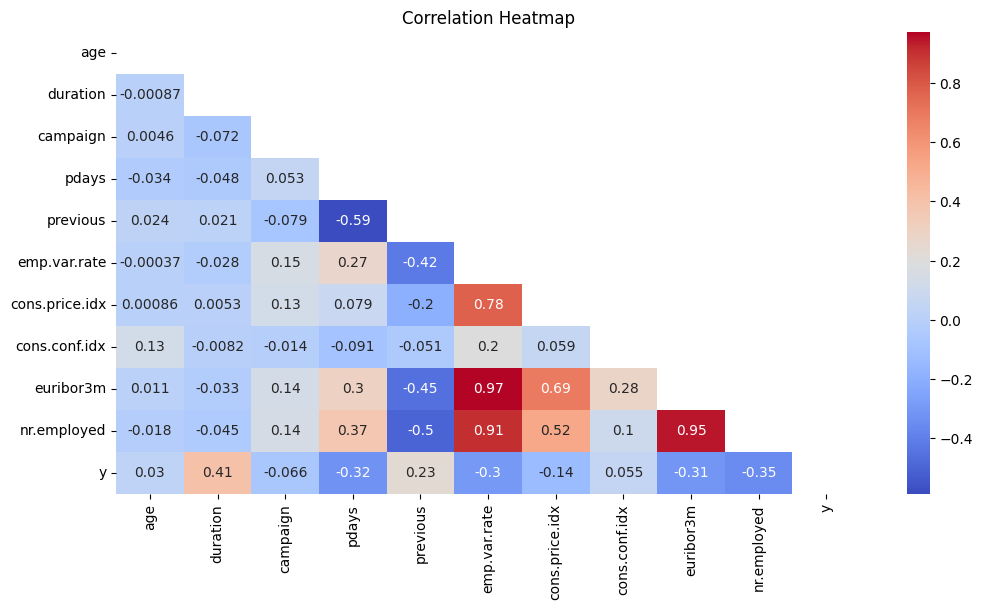

In [35]:
corr = Data.corr()
plt.figure(figsize = (12,6))
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = True, cmap = 'coolwarm', mask = mask)
plt.title('Correlation Heatmap')

#### Notes:
Highly Correlated Features:
 - We can find larger correlations between social and economic datas.
 - 'duration' (last contact duration) is the most correlated feature with target variable.

### Data Balance Problems

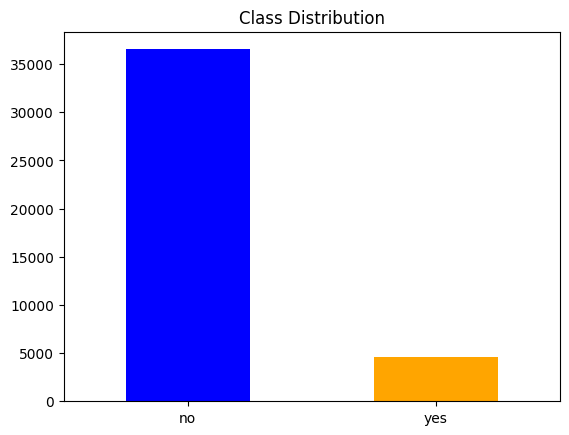

In [36]:
class_counts = Data.y.value_counts()
class_counts.plot(kind = 'bar', color = ['blue', 'orange'])
plt.xticks(ticks = [0,1], labels = ['no', 'yes'], rotation = 0)
plt.title('Class Distribution')
plt.show()

#### Notes:
By looking at the bar chart, we can see that the class distribution is highly imbalanced. To address this issue, we can use the SMOTE technique to balance the data.

### Preprocessing

In [37]:
seed = 45

In [38]:
# Split data into 80/20 in out of sample
data_train, data_test = train_test_split(Data, test_size = .2, random_state = seed)
print('Train Sets: ', data_train.shape)
print('Test Sets: ', data_test.shape)

Train Sets:  (32950, 21)
Test Sets:  (8238, 21)


In [39]:
# Split X and y
X_train = data_train.drop(['y'], axis = 1)
y_train = data_train.y
X_test = data_test.drop(['y'], axis = 1)
y_test = data_test.y

In [40]:
# Preprocessing
cat_features = X_train.select_dtypes(exclude = ['float64', 'int64']).columns
cat_features_indices = [X_train.columns.get_loc(col) for col in cat_features]
num_features = X_train.select_dtypes(['float64', 'int64']).columns

smote = SMOTENC(categorical_features = cat_features_indices, random_state = seed)
X_train_treated, y_train_treated = smote.fit_resample(X_train, y_train)

In [41]:
cat_tf = Pipeline(steps = [('encoder', OneHotEncoder(drop = 'first')), ('scaler', StandardScaler(with_mean = False))])
num_tf = Pipeline(steps = [('scaler', StandardScaler())])
col_tf = ColumnTransformer(transformers = [('num', num_tf, num_features), ('cat', cat_tf, cat_features)])

# Model: e.g. Decision Tree
mod = DecisionTreeClassifier(max_depth = 3, criterion = 'gini', random_state = seed)

## 1 Baseline Model

In [14]:
pip_baseline = Pipeline(steps = [('col_tf', col_tf), ('model', mod)])

### Tuning Grid

In [15]:
ccp_alpha_baseline = np.linspace(start = 0.0, stop = 0.02, num = 50)
max_depth_baseline = [13, 15, 17, 19]
param_baseline = {'model__ccp_alpha': ccp_alpha_baseline,
                  'model__max_depth': max_depth_baseline}

# Cross-Validation
search_baseline = GridSearchCV(pip_baseline, param_baseline, 
                               cv = 10, scoring = 'accuracy',
                               refit = True)
tic = time.time()
search_baseline.fit(X_train_treated, y_train_treated)
toc = time.time()
print('Execution time', toc-tic, 'seconds')

# CV Results
cv_baseline = pd.DataFrame({'ccp_alpha': search_baseline.cv_results_['param_model__ccp_alpha'],
                            'max_depth': search_baseline.cv_results_['param_model__max_depth'],
                            'Accuracy': search_baseline.cv_results_['mean_test_score']})
cv_baseline

Execution time 1202.6648812294006 seconds


,ccp_alpha,max_depth,Accuracy
0,0.0,13,0.925145
1,0.0,15,0.926085
2,0.0,17,0.926718
3,0.0,19,0.925538
4,0.000408,13,0.910137
...,...,...,...
195,0.019592,19,0.861179
196,0.02,13,0.861179
197,0.02,15,0.861179
198,0.02,17,0.861179


<Figure size 800x500 with 0 Axes>

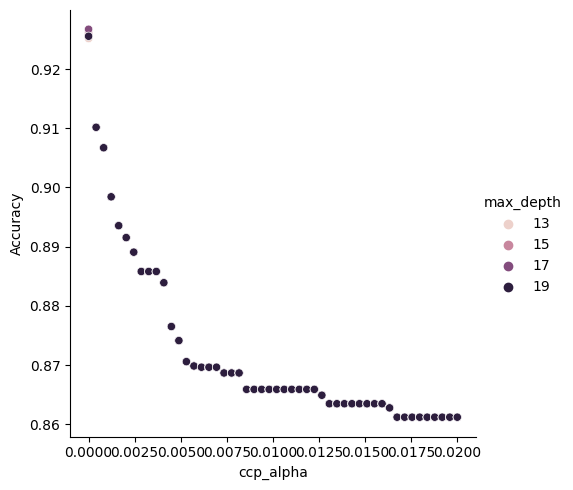

In [16]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_baseline, x = 'ccp_alpha', y = 'Accuracy', hue = 'max_depth').set(
    xlabel = 'ccp_alpha', ylabel = 'Accuracy')
plt.show()

In [17]:
search_baseline.best_estimator_

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('model',
                 DecisionTreeClassifier(max_depth=17, random_state=45))])

### Evaluation

In [18]:
y_pred_baseline = search_baseline.predict(X_test)
test_acc_baseline = accuracy_score(y_test, y_pred_baseline)
test_auc_baseline = roc_auc_score(y_test, y_pred_baseline)
cv_acc_baseline = search_baseline.best_score_
print(f'CV Accuracy: {cv_acc_baseline: .4f}')
print(f'test Accuracy: {test_acc_baseline: .4f}', f'test roc_auc: {test_auc_baseline: .4f}')

CV Accuracy:  0.9267
test Accuracy:  0.8866 test roc_auc:  0.7789


## 2 Bagging

In [111]:
mod_bagging = BaggingClassifier(estimator = DecisionTreeClassifier(max_depth = 17), n_estimators = 100, max_samples = 0.5, max_features = 1.)
pip_bagging = Pipeline(steps = [('col_tf', col_tf), ('model', mod_bagging)])

### Tuning Grid

In [112]:
n_estimators_bagging = [100, 150, 200, 250]
max_samples_bagging = [0.3, 0.5, 0.7]
max_features_bagging = [0.3, 0.5, 0.7]

param_bagging = {'model__n_estimators': n_estimators_bagging,
                 'model__max_samples': max_samples_bagging,
                 'model__max_features': max_features_bagging}

# Cross-Validation
search_bagging = GridSearchCV(pip_bagging, param_bagging, 
                              cv = 10, scoring = 'accuracy',
                              refit = True)
tic = time.time()
search_bagging.fit(X_train_treated, y_train_treated)
toc = time.time()
print('Execution time', toc-tic, 'seconds')

# CV Results
cv_bagging = pd.DataFrame({'n_estimators': search_bagging.cv_results_['param_model__n_estimators'],
                           'max_samples': search_bagging.cv_results_['param_model__max_samples'],
                           'max_features': search_bagging.cv_results_['param_model__max_features'],
                           'Accuracy': search_bagging.cv_results_['mean_test_score']})
cv_bagging

Execution time 5453.270414829254 seconds


,n_estimators,max_samples,max_features,Accuracy
0,100,0.3,0.3,0.926598
1,150,0.3,0.3,0.928855
2,200,0.3,0.3,0.924222
3,250,0.3,0.3,0.928838
4,100,0.5,0.3,0.930137
5,150,0.5,0.3,0.928154
6,200,0.5,0.3,0.928103
7,250,0.5,0.3,0.929009
8,100,0.7,0.3,0.927761
9,150,0.7,0.3,0.928752


<Figure size 800x500 with 0 Axes>

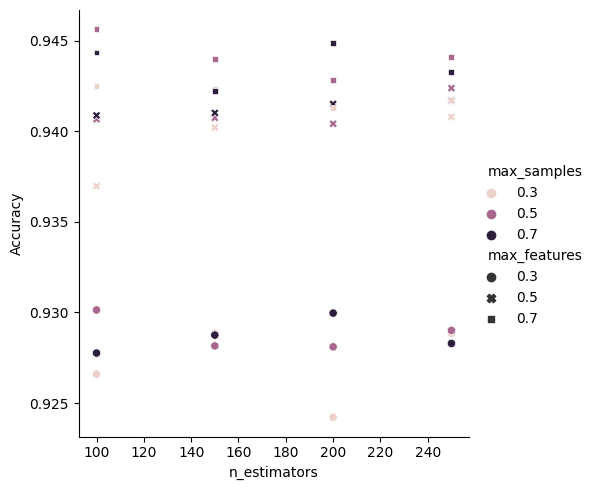

In [114]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_bagging, x = 'n_estimators', y = 'Accuracy', hue = 'max_samples', style = 'max_features').set(
    xlabel = 'n_estimators', ylabel = 'Accuracy')
plt.show()

### Evaluation

In [115]:
y_pred_bagging = search_bagging.predict(X_test)
test_acc_bagging = accuracy_score(y_test, y_pred_bagging)
test_auc_bagging = roc_auc_score(y_test, y_pred_bagging)
cv_acc_bagging = search_bagging.best_score_
print(f'CV Accuracy: {cv_acc_bagging: .4f}')
print(f'test Accuracy: {test_acc_bagging: .4f}', f'test roc_auc: {test_auc_bagging: .4f}')

CV Accuracy:  0.9456
test Accuracy:  0.9077 test roc_auc:  0.8052


## 3 Boosting

In [116]:
mod_boosting = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 17), n_estimators = 100, learning_rate = 0.1)
pip_boosting = Pipeline(steps = [('col_tf', col_tf), ('model', mod_boosting)])

### Tuning Grid

In [117]:
n_estimators_boosting = [100, 150, 200, 250]
learning_rate_boosting = [0.1, 0.3, 0.5, 0.7]

param_boosting = {'model__n_estimators': n_estimators_boosting,
                  'model__learning_rate': learning_rate_boosting}

# Cross-Validation
search_boosting = GridSearchCV(pip_boosting, param_boosting, 
                               cv = 10, scoring='accuracy', refit=True)
tic = time.time()
search_boosting.fit(X_train_treated, y_train_treated)
toc = time.time()
print('Execution time', toc-tic, 'seconds')

# CV Results
cv_boosting = pd.DataFrame({'n_estimators': np.array(search_boosting.cv_results_['param_model__n_estimators']),
                            'learning_rate': search_boosting.cv_results_['param_model__learning_rate'],
                            'Accuracy': search_boosting.cv_results_['mean_test_score']})
cv_boosting

Execution time 13930.467173099518 seconds


,n_estimators,learning_rate,Accuracy
0,100,0.1,0.945197
1,150,0.1,0.944291
2,200,0.1,0.945077
3,250,0.1,0.943521
4,100,0.3,0.943966
5,150,0.3,0.945077
6,200,0.3,0.944718
7,250,0.3,0.944530
8,100,0.5,0.946171
9,150,0.5,0.945607


In [118]:
cv_boosting = pd.DataFrame({'n_estimators': np.array(search_boosting.cv_results_['param_model__n_estimators']),
                            'learning_rate': search_boosting.cv_results_['param_model__learning_rate'],
                            'Accuracy': search_boosting.cv_results_['mean_test_score']})
cv_boosting

,n_estimators,learning_rate,Accuracy
0,100,0.1,0.945197
1,150,0.1,0.944291
2,200,0.1,0.945077
3,250,0.1,0.943521
4,100,0.3,0.943966
5,150,0.3,0.945077
6,200,0.3,0.944718
7,250,0.3,0.944530
8,100,0.5,0.946171
9,150,0.5,0.945607


<Figure size 800x500 with 0 Axes>

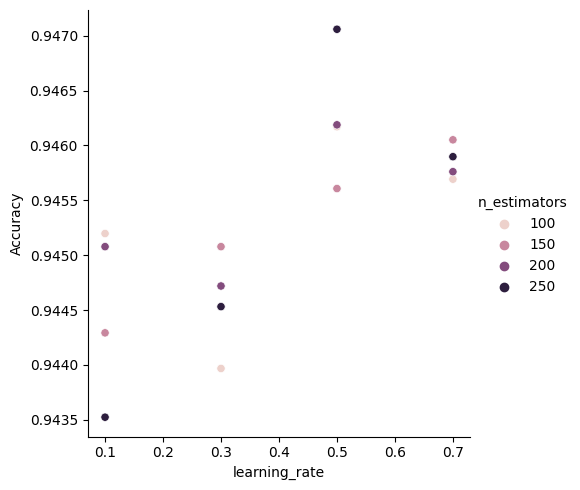

In [119]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_boosting, x = 'learning_rate', y = 'Accuracy', hue = 'n_estimators').set(
    xlabel = 'learning_rate', ylabel = 'Accuracy')
plt.show()

### Evaluation

In [120]:
y_pred_boosting = search_boosting.predict(X_test)
test_acc_boosting = accuracy_score(y_test, y_pred_boosting)
test_auc_boosting = roc_auc_score(y_test, y_pred_boosting)
cv_acc_boosting = search_boosting.best_score_
print(f'CV Accuracy: {cv_acc_boosting: .4f}')
print(f'test Accuracy: {test_acc_boosting: .4f}', f'test roc_auc: {test_auc_boosting: .4f}')

CV Accuracy:  0.9471
test Accuracy:  0.9093 test roc_auc:  0.8367


## 4 Random Forest

In [47]:
mod_rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini',
                                max_features = 'sqrt', oob_score = True,
                                random_state = seed)
pip_rf = Pipeline(steps = [('col_tf', col_tf), ('model', mod_rf)])

### Tuning Grid

In [48]:
n_estimators_rf = [50, 100, 150, 200, 250, 300]
max_features_rf = ['sqrt', 'log2', 1.0]
param_rf = {'model__n_estimators': n_estimators_rf,
            'model__max_features': max_features_rf}

# Cross-Validation
search_rf = GridSearchCV(pip_rf, param_rf, 
                         cv = 10, scoring = 'accuracy',
                         refit = True)
tic = time.time()
search_rf.fit(X_train_treated, y_train_treated)
toc = time.time()
print('Execution time', toc-tic, 'seconds')

# CV Results
cv_rf = pd.DataFrame({'n_estimators': search_rf.cv_results_['param_model__n_estimators'],
                      'max_features': search_rf.cv_results_['param_model__max_features'],
                      'Accuracy': search_rf.cv_results_['mean_test_score']})
cv_rf

Execution time 4447.726495981216 seconds


,n_estimators,max_features,Accuracy
0,50,sqrt,0.940957
1,100,sqrt,0.941590
2,150,sqrt,0.941829
3,200,sqrt,0.942017
4,250,sqrt,0.941897
5,300,sqrt,0.942000
6,50,log2,0.941778
7,100,log2,0.942256
8,150,log2,0.941692
9,200,log2,0.941709


<Figure size 800x500 with 0 Axes>

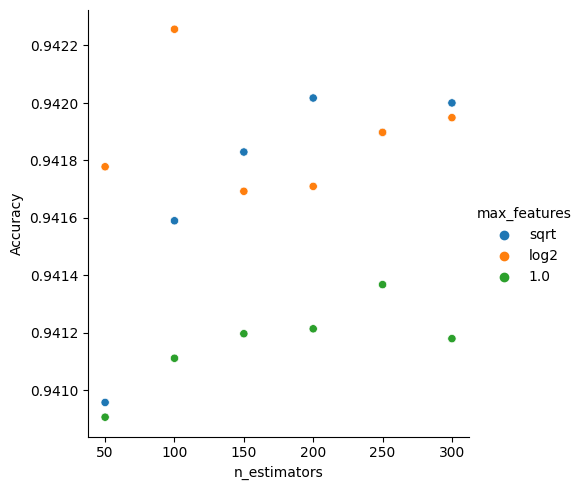

In [49]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_rf, x = 'n_estimators', y = 'Accuracy', hue = 'max_features').set(
    xlabel = 'n_estimators', ylabel = 'Accuracy' )
plt.show()

In [50]:
search_rf.best_estimator_

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(max_features='log2', oob_score=True,
                                        random_state=45))])

### Evaluation

In [51]:
y_pred_rf = search_rf.predict(X_test)
test_acc_rf = accuracy_score(y_test, y_pred_rf)
test_auc_rf = roc_auc_score(y_test, y_pred_rf)
cv_acc_rf = search_rf.best_score_
print(f'CV Accuracy: {cv_acc_rf:.4f}')
print(f'test Accuracy: {test_acc_rf:.4f}',',', f'test roc_auc: {test_auc_rf:.4f}')

CV Accuracy: 0.9423
test Accuracy: 0.9065 , test roc_auc: 0.7925


In [ ]:
#### Not Complete ####

## 5 Super Learner

In [67]:
# base learner
base_learners = [('lr', LogisticRegression()),
                 ('rf', RandomForestClassifier())]
# meta learner
meta_learner = LogisticRegression()
# super learner
mod_sl = SuperLearner(folds=5, random_state = seed, verbose=2, backend='multiprocessing')
mod_sl.add(base_learners)
mod_sl.add_meta(meta_learner)
pip_sl = Pipeline(steps=[('col_tf', col_tf), ('model', mod_sl)])

In [121]:
pip_sl

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first')),
                                                                  ('scaler',
                                                                   StandardScaler(with_...
   random_state=7115, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=45, sample_size=20, scorer=None, shuffle=False,
       verbose=2))])

### Tuning Grid

In [128]:
'''metalearner_C_sl = [0.1, 1, 10]
baselearner_lr_C_sl = [0.1, 1, 10]
baselearner_rf_n_estimators_sl = [50, 100, 150]
baselearner_rf_max_depths_sl = [5, 10, 15]



param_sl = {'model__metalearner__C': metalearner_C_sl,
            'model__base_learners__lr__C': baselearner_lr_C_sl,
            'model__base_learners_estimators__rf__n_estimators': baselearner_rf_n_estimators_sl,
            'model__base_learners_estimators__rf__max_depth': baselearner_rf_max_depths_sl}



# Cross-Validation
search_sl = GridSearchCV(pip_sl, param_sl, cv = 10, scoring='accuracy', refit = True)
tic = time.time()
search_sl.fit(X_train_treated, y_train_treated)
toc = time.time()
print('Execution time', toc-tic, 'seconds')'''

"metalearner_C_sl = [0.1, 1, 10]\nbaselearner_lr_C_sl = [0.1, 1, 10]\nbaselearner_rf_n_estimators_sl = [50, 100, 150]\nbaselearner_rf_max_depths_sl = [5, 10, 15]\n\n\n\nparam_sl = {'model__metalearner__C': metalearner_C_sl,\n            'model__base_learners__lr__C': baselearner_lr_C_sl,\n            'model__base_learners_estimators__rf__n_estimators': baselearner_rf_n_estimators_sl,\n            'model__base_learners_estimators__rf__max_depth': baselearner_rf_max_depths_sl}\n\n\n\n# Cross-Validation\nsearch_sl = GridSearchCV(pip_sl, param_sl, cv = 10, scoring='accuracy', refit = True)\ntic = time.time()\nsearch_sl.fit(X_train_treated, y_train_treated)\ntoc = time.time()\nprint('Execution time', toc-tic, 'seconds')"

In [131]:
"""# CV Results
cv_sl = pd.DataFrame({'lr__C': search_sl.cv_results_['param_model__base_estimators__lr__C'],
                      'rf__n_estimators': search_sl.cv_results_['param_model__base_estimators__rf__n_estimators'],
                      'rf__max_depth': search_sl.cv_results_['param_model__base_estimators__rf__max_depth'],
                      'metalearner__C': search_sl.cv_results_['param_metalearner__C'],
                      'Accuracy': search_sl.cv_results_['mean_test_score']})
cv_sl"""

"# CV Results\ncv_sl = pd.DataFrame({'lr__C': search_sl.cv_results_['param_model__base_estimators__lr__C'],\n                      'rf__n_estimators': search_sl.cv_results_['param_model__base_estimators__rf__n_estimators'],\n                      'rf__max_depth': search_sl.cv_results_['param_model__base_estimators__rf__max_depth'],\n                      'metalearner__C': search_sl.cv_results_['param_metalearner__C'],\n                      'Accuracy': search_sl.cv_results_['mean_test_score']})\ncv_sl"

In [132]:
'''# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_rf, x = 'n_estimators', y = 'Accuracy', hue = 'max_features').set(
    xlabel = 'n_estimators', ylabel = 'Accuracy' )
plt.show()'''

"# CV Results Visualization\nplt.figure(figsize = (8,5))\nsns.relplot(data = cv_rf, x = 'n_estimators', y = 'Accuracy', hue = 'max_features').set(\n    xlabel = 'n_estimators', ylabel = 'Accuracy' )\nplt.show()"

### Evaluation

In [133]:
'''y_pred_sl = search_sl.predict(X_test)
test_acc_sl = accuracy_score(y_test, y_pred_sl)
test_auc_sl = roc_auc_score(y_test, y_pred_sl)
cv_acc_sl = search_sl.best_score_
print(f'CV Accuracy: {cv_acc_sl:.4f}')
print(f'test Accuracy: {test_acc_sl:.4f}',',', f'test roc_auc: {test_auc_sl:.4f}')'''

"y_pred_sl = search_sl.predict(X_test)\ntest_acc_sl = accuracy_score(y_test, y_pred_sl)\ntest_auc_sl = roc_auc_score(y_test, y_pred_sl)\ncv_acc_sl = search_sl.best_score_\nprint(f'CV Accuracy: {cv_acc_sl:.4f}')\nprint(f'test Accuracy: {test_acc_sl:.4f}',',', f'test roc_auc: {test_auc_sl:.4f}')"

## Summary

In [130]:
methods = {'Baseline Model': [cv_acc_baseline, test_acc_baseline, test_auc_baseline],
           'Bagging': [cv_acc_bagging, test_acc_bagging, test_auc_bagging],
           'Boosting': [cv_acc_boosting, test_acc_boosting, test_auc_boosting],
           'Random Forest': [cv_acc_rf, test_acc_rf, test_auc_rf]}
           #'Super Learner': [cv_acc_sl, test_acc_sl, test_auc_sl]}
summary = pd.DataFrame.from_dict(methods, orient='index', columns=['cv Accuracy', 'test Accuracy', 'test roc_auc'])
summary

,cv Accuracy,test Accuracy,test roc_auc
Baseline Model,0.926718,0.886623,0.778916
Bagging,0.945624,0.907745,0.805203
Boosting,0.947060,0.909323,0.836678
Random Forest,0.942256,0.906531,0.792469


The method that performed best on the test set was Boosting.

In [ ]:
'''Baseline Model	0.926718	0.886623	0.778916
Bagging	0.945624	0.907745	0.805203
Boosting	0.947060	0.909323	0.836678
Random Forest	0.942256	0.906531	0.792469'''